In [1]:
import traceback
import functools
import multiprocessing
from multiprocessing import Pool

import numpy as np

import pandas as pd

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits

import ccdproc

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
mmirs = WFSFactory(wfs="mmirs")

<IPython.core.display.Javascript object>


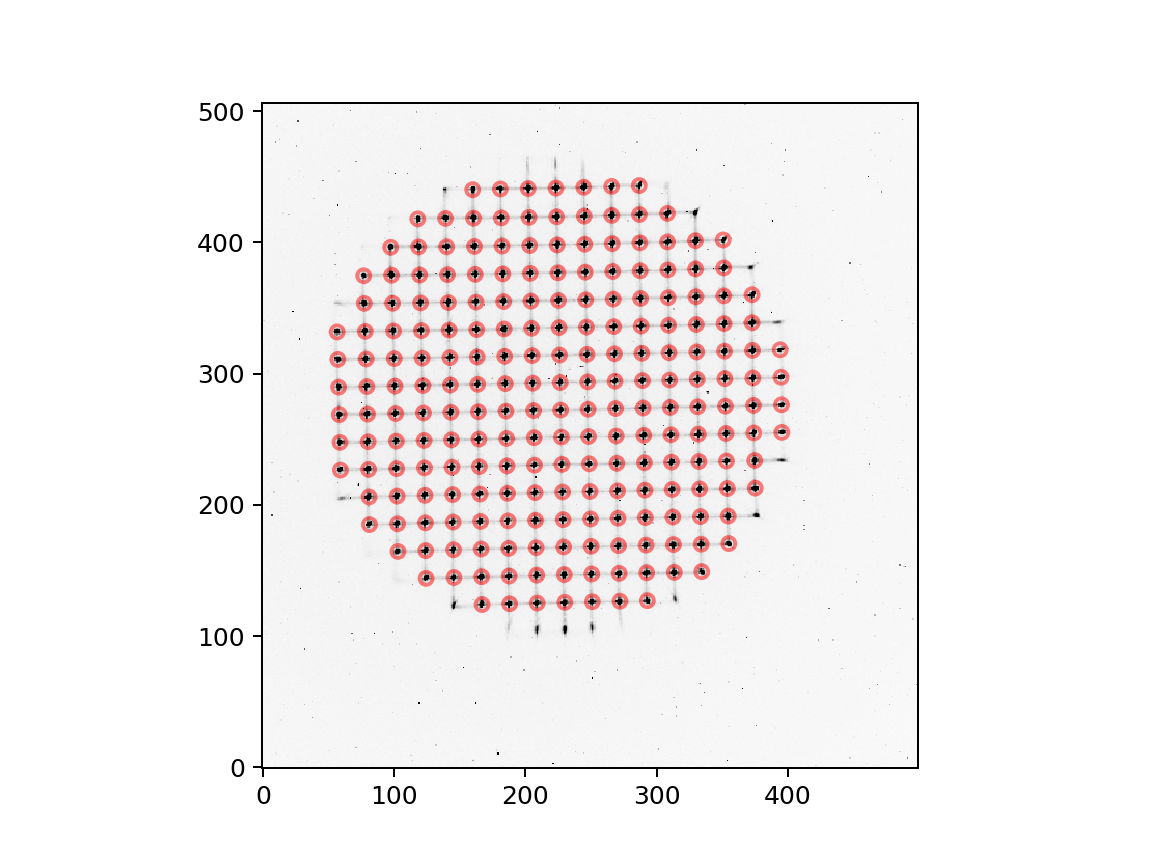

<IPython.core.display.Javascript object>


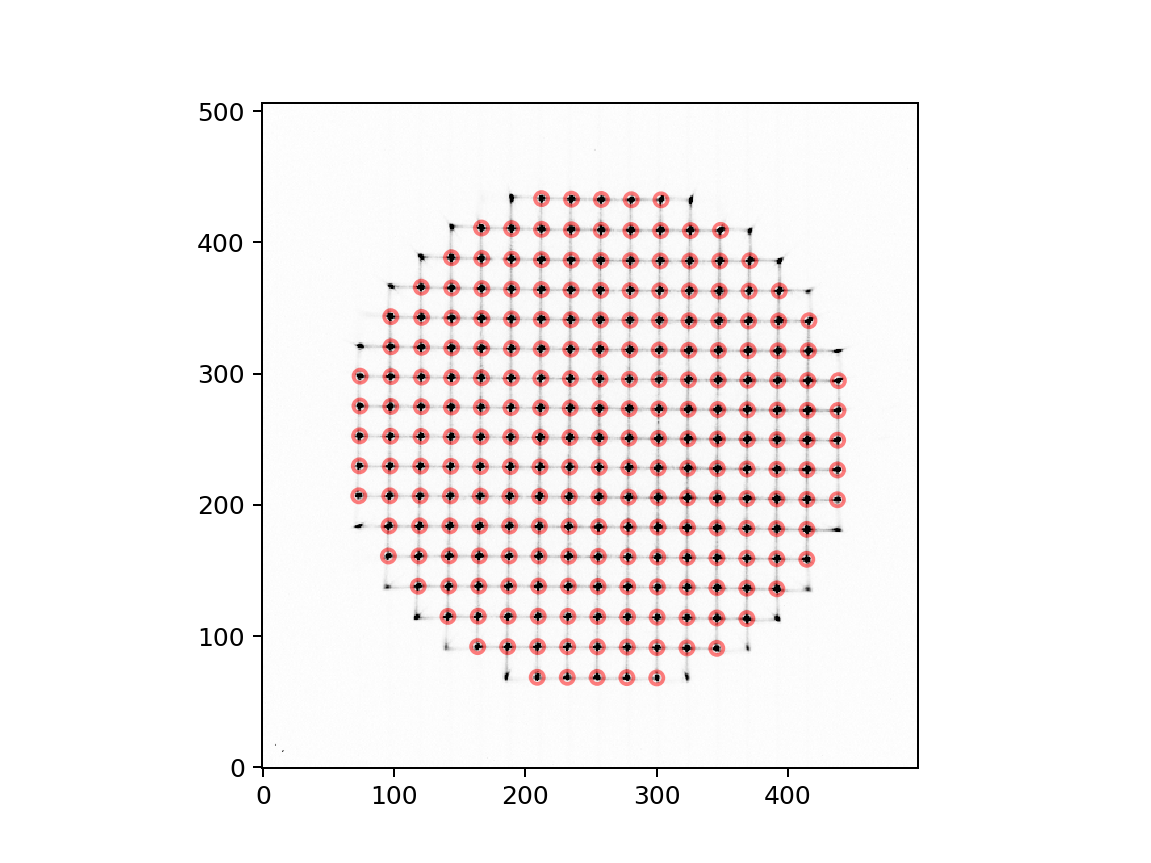

In [4]:
plt.show()

In [ ]:
fig, ax = plt.subplots()
mmirs.drawoutline(ax)

# Some representative positions that vignette on different edges of the mirror
mmirs.plotgrid(-50, -60, ax)
mmirs.plotgrid(-45, -40, ax)
mmirs.plotgrid(-7, -52, ax)
mmirs.plotgrid(50, 60, ax)
mmirs.plotgrid(45, 40, ax)
mmirs.plotgrid(7, 52, ax)
fig.show()

<IPython.core.display.Javascript object>


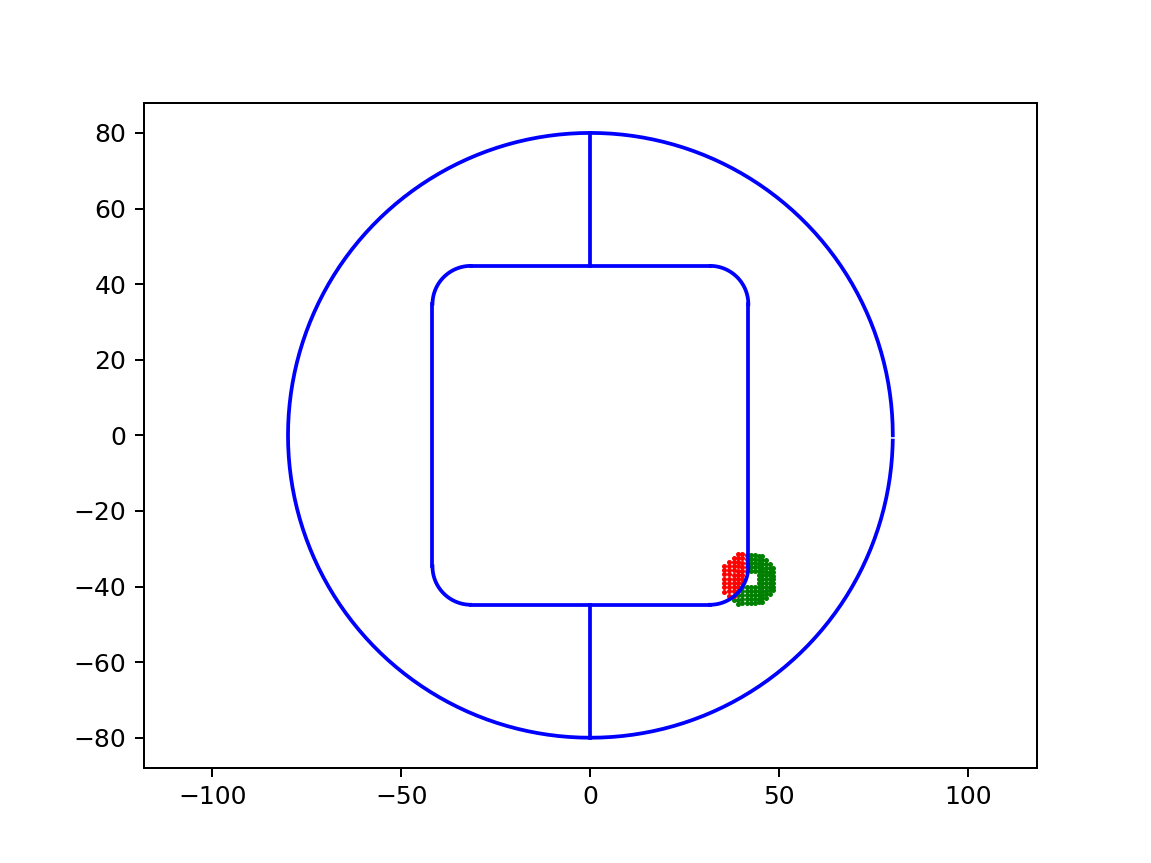

In [14]:
# The PacMan from last WFS image on 2017.1019
fig, ax = plt.subplots()
mmirs.drawoutline(ax)
mmirs.plotgrid(43.687, -39.144, ax)  # use GUIDERX/Y to place and then CA to rotate to match
plt.show()

<IPython.core.display.Javascript object>


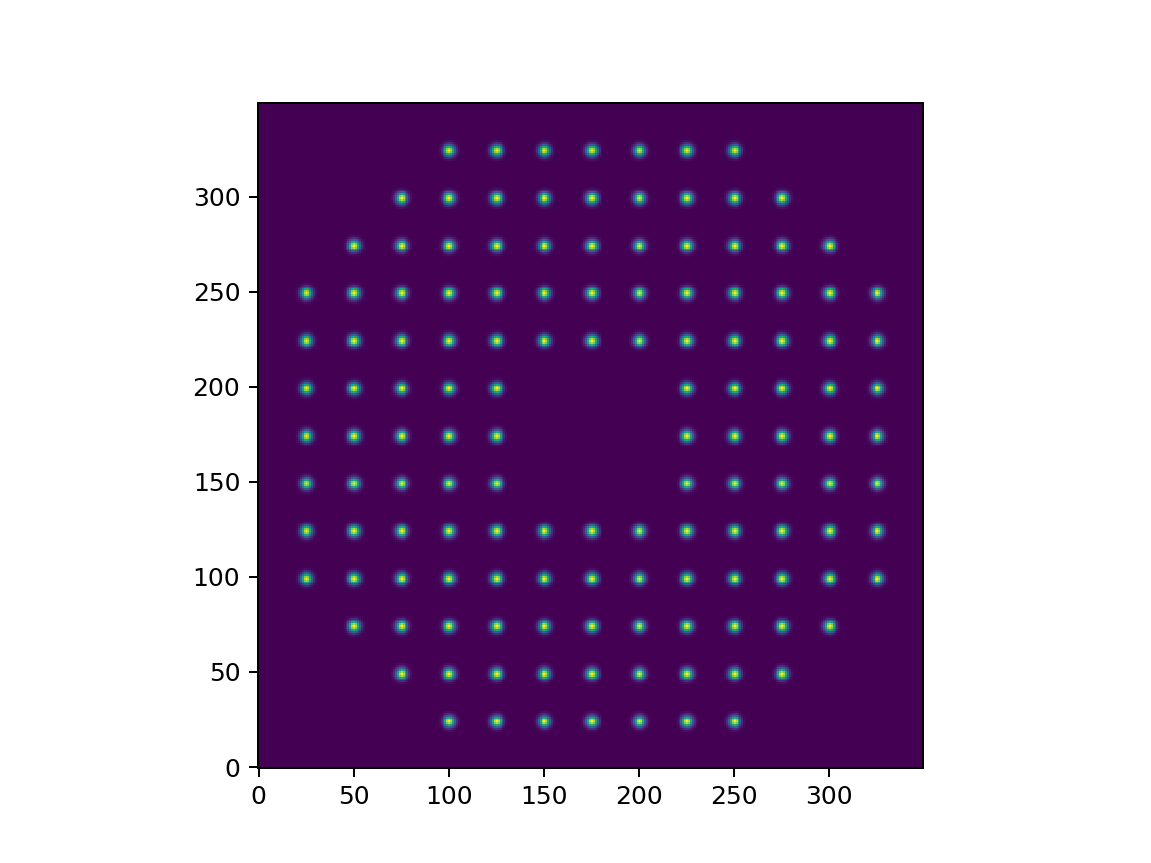

In [29]:
data, hdr = check_wfsdata("/Users/tim/MMT/wfsdat/20171013/mmirs_wfs_rename_0566.fits", header=True)
data, hdr = check_wfsdata("/Users/tim/MMT/wfsdat/20181120/mmirs_wfs_0193.fits", header=True)
im = mmirs.pupil_mask(hdr)
plt.imshow(im, origin='lower')
plt.show()

In [22]:
import photutils

In [28]:
t = photutils.detection.find_peaks(im, 0.8, box_size=5, centroid_func=photutils.centroids.centroid_com)
t[t['peak_value'] == t['peak_value'].max()][0]

x_peak,y_peak,peak_value,x_centroid,y_centroid
int64,int64,float64,float64,float64
324,100,1.0000000000000004,324.0,99.99999999999997


In [ ]:
fig, ax = plt.subplots()
mmirs.drawoutline(ax)
mmirs.plotgrid(-57.08, 25.74, ax)
fig.show()

In [ ]:
%cd /Volumes/LaCie\ 8TB/wfsdat/20150927

In [ ]:
ic = ccdproc.ImageFileCollection('.', glob_include="mmirs_wfs*.fits", keywords=['wfsname', 'guiderx', 'guidery'])

In [ ]:
cam1 = ic.summary['file'][ic.summary['wfsname'] == '                        mmirs1']
cam2 = ic.summary['file'][ic.summary['wfsname'] == '                        mmirs2']

In [ ]:
cam1_proc = []
cam2_proc = []
for f in cam1:
    data, hdr = mmirs.process_image(f)
    cam1_proc.append(data)
for f in cam2:
    data, hdr = mmirs.process_image(f)
    cam2_proc.append(data)

In [ ]:
cam1_mean = np.mean(cam1_proc, axis=0)
cam2_mean = np.mean(cam2_proc, axis=0)

In [ ]:
hdu1 = fits.PrimaryHDU(cam1_mean)
hdu1.writeto('cam1_mean.fits', overwrite=True)
hdu2 = fits.PrimaryHDU(cam2_mean)
hdu2.writeto('cam2_mean.fits', overwrite=True)

In [ ]:
c1 = fits.open("cam1_mean.fits")[0].data
r1, rh1 = check_wfsdata("/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/mmirs_camera1_ref.fits", header=True)
r1 = mmirs.trim_overscan(r1, hdr=hdr)
comb1 = c1 + 0.1*r1
hh = fits.PrimaryHDU(comb1)
hh.writeto("comb1.fits", overwrite=True)

In [ ]:
len(cam1_proc), len(cam2_proc)

In [ ]:
cam2_proc[0].shape

In [ ]:
c2 = fits.open("cam2_mean.fits")[0].data
r2, rh2 = check_wfsdata("/Users/tim/MMT/mmtwfs/mmtwfs/data/ref_images/mmirs_camera2_ref.fits", header=True)
r2 = mmirs.trim_overscan(r2, hdr=hdr)
comb2 = c2 + 0.1*r2
hh = fits.PrimaryHDU(comb2)
hh.writeto("comb2.fits", overwrite=True)

In [ ]:
df = ic.summary.to_pandas()

In [ ]:
df1 = df[df['wfsname'].str.contains('mmirs1')]
df2 = df[df['wfsname'].str.contains('mmirs2')]

In [ ]:
df2['guiderx'].mean(), df2['guidery'].max()

In [ ]:
df1_pos = df1.drop_duplicates(subset=['guiderx', 'guidery'])
df2_pos = df2.drop_duplicates(subset=['guiderx', 'guidery'])

In [ ]:
fig, ax = plt.subplots()
mmirs.drawoutline(ax)
for i, p in df1_pos.iterrows():
    mmirs.plotgrid(p['guiderx'], p['guidery'], ax)
for i, p in df2_pos.iterrows():
    mmirs.plotgrid(p['guiderx'], p['guidery'], ax)
ax.set_xlabel("GUIDERX (mm)")
ax.set_ylabel("GUIDERY (mm)")
fig.show()

In [ ]:
fig.savefig("wfs_positions.pdf")

In [ ]:
7.4 * 206265/280e3 * 486

In [ ]:
206265 * 1.22 * 0.5e-3 / 60

In [ ]:
ngood = 0
ngood += 1